In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from collections import Counter
import cryptoaml.datareader as cdr

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from skmultiflow.meta import LearnNSE
from skmultiflow.meta import LeverageBagging
from skmultiflow.trees import HoeffdingTree
from sklearn.tree import DecisionTreeClassifier
from skmultiflow.meta import AdaptiveRandomForest
from cryptoaml.models import AdaptiveXGBoostClassifier

from sklearn.exceptions import UndefinedMetricWarning

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NeighbourhoodCleaningRule

from cryptoaml.metrics import (
    results_table, 
    plot_metric_dist,
    plot_feature_imp,
    print_model_params, 
    plot_result_matrices,
    display_metrics_stats,
    elliptic_time_indexed_results
)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

/home/delinvas/anaconda3/envs/btc-classifier/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
elliptic = cdr.get_data("elliptic")
data = elliptic.train_test_split(train_size=0.7, 
                                 feat_set="AF", 
                                 inc_meta=False,
                                 inc_unknown=False)

train_data = data.train_X
train_data["class"] = data.train_y
test_data = data.test_X
test_data["class"] = data.test_y 
data = train_data.append(test_data, ignore_index=True)

In [3]:
def evaluate_batch_incremental(model):
    
    results = {}
    results_time = []
    true_test = []
    predictions_test = []
    
    for ts in np.arange(data["ts"].min(), data["ts"].max()):
        
        # get training data for the current timestep 
        train_set = data[data["ts"] == ts]
        train_set_X = train_set.iloc[:,:-1]
        train_set_y = train_set["class"]      

        # partially fit model 
        model.partial_fit(train_set_X.values, train_set_y.values)    

        # get test data for the current timestep + 1 
        test_set = data[data["ts"] == ts + 1]
        test_set_X = test_set.iloc[:,:-1].values
        test_set_y = test_set["class"].values
    
        # predict test data for the current timestep + 1
        y_pred = model.predict(test_set_X)
        evaluation_f1 = f1_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_recall = recall_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_precision = precision_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_accuracy = accuracy_score(test_set_y, y_pred, normalize=True)
        
#         print("TS {}".format(ts + 1))
#         print(evaluation_f1)
        
        # print evaluation 
#         print("Timestep {}\n\t\tF1({})\n\t\tRecall({})\n\t\tPrecision({})\n\t\tAccuracy({})"
#               .format(ts+1, 
#                       round(evaluation_f1, 3), 
#                       round(evaluation_recall, 3),
#                       round(evaluation_precision, 3),
#                       round(evaluation_accuracy, 3)))
        
        # take note of predictions after timestep 34 (evaluation set)
        if ts+1 >= 35:
            true_test.append(test_set_y)
            predictions_test.append(y_pred)
            label_count = test_set["class"].value_counts()
            results_time.append({"timestep": ts + 1, 
                                 "score":evaluation_f1, 
                                 "total_pos_label": label_count.tolist()[1]}) 

            
    test_results = {}
    f1_score_test = f1_score(np.concatenate(true_test, axis=0), 
                        np.concatenate(predictions_test, axis=0), 
                        average='binary')
    recall_score_test = recall_score(np.concatenate(true_test, axis=0),   
                                np.concatenate(predictions_test, axis=0), 
                                average='binary')
    precision_score_test = precision_score(np.concatenate(true_test, axis=0),   
                                      np.concatenate(predictions_test, axis=0), 
                                      average='binary')
    accuracy_score_test = accuracy_score(np.concatenate(true_test, axis=0),   
                                    np.concatenate(predictions_test, axis=0), 
                                    normalize=True)
    confusion_matrix_test = confusion_matrix(np.concatenate(true_test, axis=0), 
                                             np.concatenate(predictions_test, axis=0))
    
    test_results["f1"] = round(f1_score_test, 3)   
    test_results["recall"] = round(recall_score_test, 3)   
    test_results["precision"] = round(precision_score_test, 3)   
    test_results["accuracy"] = round(accuracy_score_test, 3)   
    test_results["confusion_matrix"] = confusion_matrix_test  
    
    results["test_results"] = test_results
    results["time_metrics"] = pd.DataFrame(results_time)   

    return results

In [4]:
# # classification methods for data streams 
experiment_3_results = {}
experiment_3_results["ARF"] = {}
experiment_3_results["AXGBr"] = {}
experiment_3_results["AXGBp"] = {}
experiment_3_results["ASXGB"] = {}
experiment_3_results["ARF"]["elliptic_AF"] = {}
experiment_3_results["AXGBr"]["elliptic_AF"] = {}
experiment_3_results["AXGBp"]["elliptic_AF"] = {}
experiment_3_results["ASXGB"]["elliptic_AF"] = {}

# 1. Adaptive Random Forest (instance-incremental) 
print("Evaluating ARF")
arf = AdaptiveRandomForest(performance_metric="kappa")
experiment_3_results["ARF"]["elliptic_AF"] = evaluate_batch_incremental(arf)

Evaluating ARF


In [5]:
# 2. Adapative Extreme Gradient Boosting with Replacement
# 3. Adapative Extreme Gradient Boosting with Push

# Adaptive XGBoost classifier parameters
n_estimators = 30       # Number of members in the ensemble
learning_rate = 0.3     # Learning rate or eta
max_depth = 6           # Max depth for each tree in the ensemble
max_window_size = 1000  # Max window size
min_window_size = 1     # set to activate the dynamic window strategy
detect_drift = False    # Enable/disable drift detection

print("Evaluating AXGBr")
AXGBr = AdaptiveXGBoostClassifier(update_strategy='replace',
                                  n_estimators=n_estimators,
                                  learning_rate=learning_rate,
                                  max_depth=max_depth,
                                  max_window_size=max_window_size,
                                  min_window_size=min_window_size,
                                  detect_drift=detect_drift)
experiment_3_results["AXGBr"]["elliptic_AF"] = evaluate_batch_incremental(AXGBr)

print("Evaluating AXGBp")
AXGBp = AdaptiveXGBoostClassifier(update_strategy='push',
                                  n_estimators=n_estimators,
                                  learning_rate=learning_rate,
                                  max_depth=max_depth,
                                  max_window_size=max_window_size,
                                  min_window_size=min_window_size,
                                  detect_drift=detect_drift)
experiment_3_results["AXGBp"]["elliptic_AF"] = evaluate_batch_incremental(AXGBp)

Evaluating AXGBr
Evaluating AXGBp


In [6]:
class AdaptiveStackedBoostClassifier():
    def __init__(self,
                 min_window_size=None, 
                 max_window_size=2000,
                 n_base_models=5,
                 n_rounds_eval_base_model=3,
                 meta_learner_train_ratio=0.4):
        
        self._first_run = True
        
        self.max_window_size = max_window_size
        self.min_window_size = min_window_size
        
        # validate 'n_base_models' 
        if n_base_models <= 1:
            raise ValueError("'n_base_models' must be > 1")
        self._n_base_models = n_base_models
        # validate 'n_rounds_eval_base_model' 
        if n_rounds_eval_base_model > n_base_models or n_rounds_eval_base_model <= 0:
            raise ValueError("'n_rounds_eval_base_model' must be > 0 and <= to 'n_base_models'")
        self._n_rounds_eval_base_model = n_rounds_eval_base_model
        self._meta_learner = xgb.XGBClassifier()
        self.meta_learner_train_ratio = meta_learner_train_ratio
        self._X_buffer = np.array([])
        self._y_buffer = np.array([])

        # 3*N matrix 
        # 1st row - base-level model
        # 2nd row - evaluation rounds 
        self._base_models = [[None for x in range(n_base_models)] for y in range(3)]
        
        self._reset_window_size()
        
    def _adjust_window_size(self):
        if self._dynamic_window_size < self.max_window_size:
            self._dynamic_window_size *= 2
            if self._dynamic_window_size > self.max_window_size:
                self.window_size = self.max_window_size
            else:
                self._window_size = self._dynamic_window_size

    def _reset_window_size(self):
        if self.min_window_size:
            self._dynamic_window_size = self.min_window_size
        else:
            self._dynamic_window_size = self.max_window_size
        self._window_size = self._dynamic_window_size

        
    def partial_fit(self, X, y):
        if self._first_run:
            self._X_buffer = np.array([]).reshape(0, X.shape[1])
            self._y_buffer = np.array([])
            self._first_run = False
                           
        self._X_buffer = np.concatenate((self._X_buffer, X))
        self._y_buffer = np.concatenate((self._y_buffer, y))
        while self._X_buffer.shape[0] >= self._window_size:
            self._train_on_mini_batch(X=self._X_buffer[0:self._window_size, :],
                                      y=self._y_buffer[0:self._window_size])
            delete_idx = [i for i in range(self._window_size)]
            self._X_buffer = np.delete(self._X_buffer, delete_idx, axis=0)
            self._y_buffer = np.delete(self._y_buffer, delete_idx, axis=0)
    
    def _train_new_base_model(self, X_base, y_base, X_meta, y_meta):
        
        # new base-level model  
        new_base_model = xgb.XGBClassifier()
        # first train the base model on the base-level training set 
        new_base_model.fit(X_base, y_base)
        # then extract the predicted probabilities to be added as meta-level features
        y_predicted = new_base_model.predict_proba(X_meta)   
        # once the meta-features for this specific base-model are extracted,
        # we incrementally fit this base-model to the rest of the data,
        # this is done so this base-model is trained on a full batch 
        new_base_model.fit(X_meta, y_meta, xgb_model=new_base_model.get_booster())
        return new_base_model, y_predicted
    
    def _construct_meta_features(self, meta_features):
        
        # get size of of meta-features
        meta_features_shape = meta_features.shape[1]  
        # get expected number of features,
        # binary probabilities from the total number of base-level models
        meta_features_expected = self._n_base_models * 2
        
        # since the base-level models list is not full, 
        # we need to fill the features until the list is full, 
        # so we set the remaining expected meta-features as 0
        if meta_features_shape < meta_features_expected:
            diff = meta_features_expected - meta_features_shape
            empty_features = np.zeros((meta_features.shape[0], diff))
            meta_features = np.hstack((meta_features, empty_features)) 
        return meta_features 
        
    def _get_weakest_base_learner(self):
        
        # loop rounds
        worst_model_idx = None 
        worst_performance = 1
        for idx in range(len(self._base_models[0])):
            current_round = self._base_models[1][idx]
            if current_round < self._n_rounds_eval_base_model:
                continue 
            
            current_performance = self._base_models[2][idx].sum()
            if current_performance < worst_performance:
                worst_performance = current_performance 
                worst_model_idx = idx

        return worst_model_idx
    
    def _train_on_mini_batch(self, X, y):
        
        # ----------------------------------------------------------------------------
        # STEP 1: split mini batch to base-level and meta-level training set
        # ----------------------------------------------------------------------------
        base_idx = int(self._window_size * (1.0 - self.meta_learner_train_ratio))
        X_base = X[0: base_idx, :]
        y_base = y[0: base_idx] 

                
#         ncr = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
#         counter = Counter(y_base)
#         n_neighbours = counter[1] - 1 if counter[1] <= 5 else 5
#         sm = SMOTE(k_neighbors=n_neighbours)

#         X_base, y_base = ncr.fit_resample(X_base, y_base)
#         X_base, y_base = sm.fit_resample(X_base, y_base)

        

        # this part will be used to train the meta-level model,
        # and to continue training the base-level models on the rest of this batch
        X_meta = X[base_idx:self._window_size, :]  
        y_meta = y[base_idx:self._window_size]
        
        # ----------------------------------------------------------------------------
        # STEP 2: train previous base-models 
        # ----------------------------------------------------------------------------
        meta_features = []
        base_models_len = self._n_base_models - self._base_models[0].count(None)
        if base_models_len > 0: # check if we have any base-level models         
            base_model_performances = self._meta_learner.feature_importances_
            for b_idx in range(base_models_len): # loop and train and extract meta-level features 
                    
                # continuation of training (incremental) on base-level model,
                # using the base-level training set 
                base_model = self._base_models[0][b_idx]
                base_model.fit(X_base, y_base, xgb_model=base_model.get_booster())
                y_predicted = base_model.predict_proba(X_meta) # extract meta-level features 
                                
                # extract meta-features 
                meta_features = y_predicted if b_idx == 0 else np.hstack((meta_features, y_predicted))                    
                
                # once the meta-features for this specific base-model are extracted,
                # we incrementally fit this base-model to the rest of the data,
                # this is done so this base-model is trained on a full batch 
                base_model.fit(X_meta, y_meta, xgb_model=base_model.get_booster())
                                
                # update base-level model list 
                self._base_models[0][b_idx] = base_model
                current_round = self._base_models[1][b_idx]
                last_performance = base_model_performances[b_idx * 2] + base_model_performances[(b_idx*2)+1] 
                self._base_models[2][b_idx][current_round%self._n_rounds_eval_base_model] = last_performance
                self._base_models[1][b_idx] = current_round + 1
                
        # ----------------------------------------------------------------------------
        # STEP 3: with each new batch, we create/train a new base model 
        # ----------------------------------------------------------------------------
        new_base_model, new_base_model_meta_features = self._train_new_base_model(X_base, y_base, X_meta, y_meta)

        insert_idx = base_models_len
        if base_models_len == 0:
            meta_features = new_base_model_meta_features
        elif base_models_len > 0 and base_models_len < self._n_base_models: 
            meta_features = np.hstack((meta_features, new_base_model_meta_features))     
        else: 
            insert_idx = self._get_weakest_base_learner()           
            meta_features[:, insert_idx * 2] = new_base_model_meta_features[:,0]
            meta_features[:, (insert_idx * 2) + 1] = new_base_model_meta_features[:,1]
            
        self._base_models[0][insert_idx] = new_base_model 
        self._base_models[1][insert_idx] = 0 
        self._base_models[2][insert_idx] = np.zeros(self._n_rounds_eval_base_model) 

        # STEP 4: train the meta-level model 
        meta_features = self._construct_meta_features(meta_features)
        
        if base_models_len == 0:
            self._meta_learner.fit(meta_features, y_meta)
        else:
            self._meta_learner.fit(meta_features, y_meta, xgb_model=self._meta_learner.get_booster())

    def predict(self, X):
      
        # only one model in ensemble use its predictions 
        base_models_len = self._n_base_models - self._base_models[0].count(None)
        if base_models_len == 1:
            return self._base_models[0][0].predict(X)
        
        # predict via meta learner 
        meta_features = []           
        for b_idx in range(base_models_len):
            y_predicted = self._base_models[0][b_idx].predict_proba(X) 
            meta_features = y_predicted if b_idx == 0 else np.hstack((meta_features, y_predicted))                    
        meta_features = self._construct_meta_features(meta_features)
        return self._meta_learner.predict(meta_features)

In [7]:
# 4. Proposed Method
print("Evaluating ASXGB")
ASXGB = AdaptiveStackedBoostClassifier()
experiment_3_results["ASXGB"]["elliptic_AF"] = evaluate_batch_incremental(ASXGB)

Evaluating ASXGB


In [8]:
# # output final results 
# results_df = pd.DataFrame()
# for key in experiment_3_results.keys():
#     tmp_results = experiment_3_results[key]
#     tmp_results = {**{"model":key}, **tmp_results["test_results"]}
#     results_df = results_df.append(tmp_results, ignore_index=True)
    
# results_df.set_index("model", inplace=True)
# display(results_df)

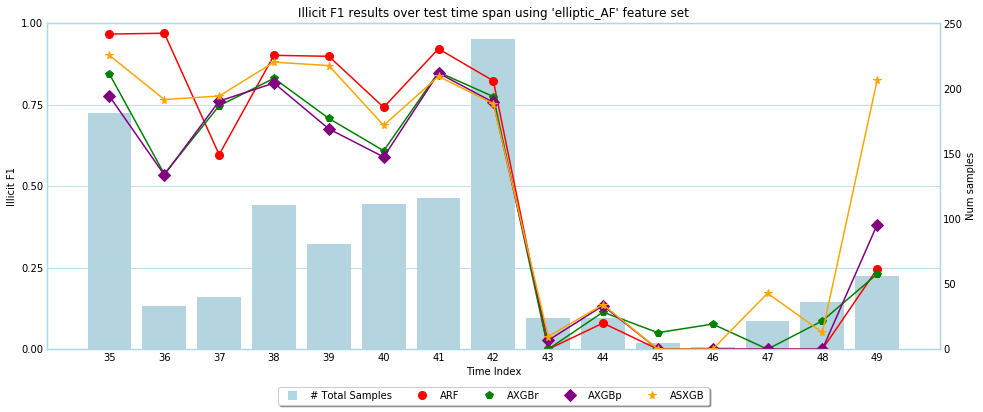

In [9]:
elliptic_time_indexed_results(experiment_3_results)